### Description
- Prediction differences between labels at time 0 and 24hr

In [1]:
library(caret) # import this before glmnet to avoid rlang version problem
library(data.table)
library(tidyverse)
library(lubridate)
library(Matrix)
library(glmnet)
library(bit64)
library(pROC)
library(rms)

Loading required package: lattice

Loading required package: ggplot2

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v tibble  3.0.4     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.0
v purrr   0.3.4     

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::between()   masks data.table::between()
x dplyr::filter()    masks stats::filter()
x dplyr::first()     masks data.table::first()
x dplyr::lag()       masks stats::lag()
x dplyr::last()      masks data.table::last()
x purrr::lift()      masks caret::lift()
x purrr::transpose() masks data.table::transpose()


Attaching package: 'lubridate'


The following objects are masked from 'package:data.table':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from 'package:base':

    date, intersect, setdiff, union



Attaching package: 'Matrix'


The following 

In [2]:
# directories
datadir = "../../DataTD"
cohortdir = "../../OutputTD/1_cohort"
featuredir = "../../OutputTD/2_features"
modeldir4 = "../../OutputTD/3_models/1_4_cohort"

In [3]:
diff <- read.csv(file.path(modeldir4, '1_4_cohort_diff_full_features.csv'))
nrow(diff)
colnames(diff)
# diff <-  diff %>% mutate(admit_time = ymd_hms(admit_time))

[1] 40709

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "abs_diff0_24"            "admit_time"             
 [5] "feature_type"            "features"               
 [7] "values"                  "first_label"            
 [9] "death_24hr_recent_label" "death_24hr_max_label"   
[11] "time"

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

ERROR while rich displaying an object: Error in FUN(X[[i]], ...): object 'pred_first' not found

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr:

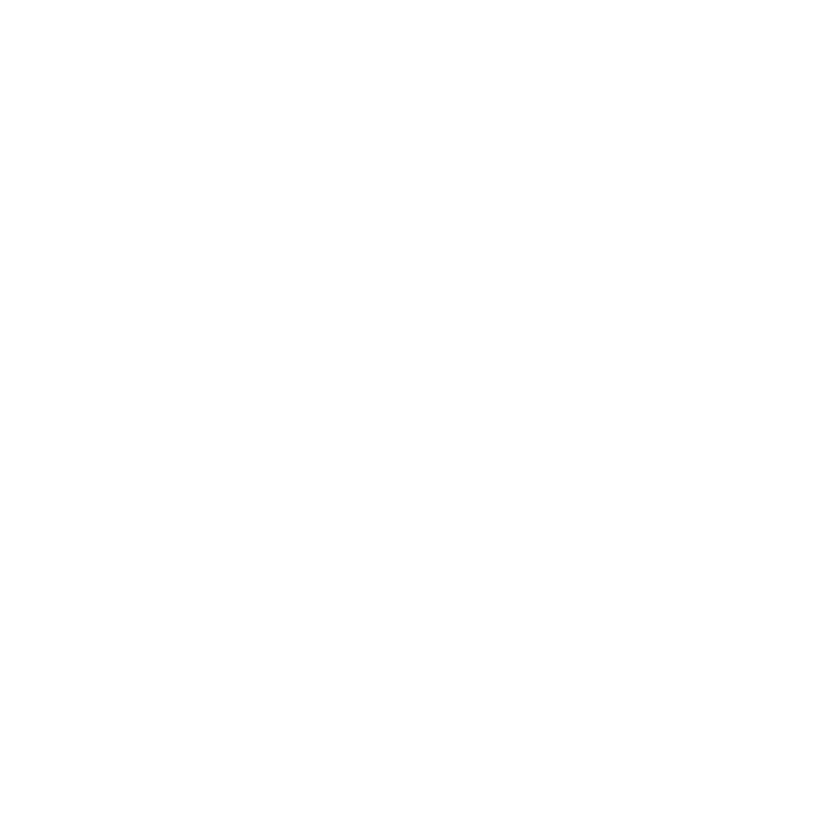

In [5]:
options(repr.plot.width=7, repr.plot.height=7)

ggplot(diff, aes(x=pred_first, y=pred_death_24hr_recent)) + 
    geom_point(color = "#0072B2", size = 1) + xlim(0,1) + ylim(0,1) +
    geom_abline(intercept = 0, slope = 1, size = 0.7) +
    geom_abline(intercept = 0.3, slope = 1, size = 0.7, linetype=2, color = "#D55E00") +
    geom_abline(intercept = -0.3, slope = 1, size = 0.7, linetype=2, color = "#D55E00") +
    scale_x_continuous(name = "predicted values for time 0", expand = c(0, 0), limits=c(0, 1), 
                       breaks=c(0, 0.2, 0.4, 0.6, 0.8, 1)) + 
    scale_y_continuous(name = " predicted values for time 24", expand = c(0, 0), limits=c(0, 1), 
                       breaks=c(0, 0.2, 0.4, 0.6, 0.8, 1)) +
    theme(axis.text=element_text(size=12),
          axis.text.x = element_text(margin=margin(0, 0, 10, 0)),
          axis.text.y = element_text(margin=margin(0, 0, 0, 10)),
          plot.title = element_text(size=16, hjust=0.5, margin=margin(0, 0, 10, 0)),
          axis.title=element_text(size=14)) +
     labs(title = "Predicted values: time 0 vs time 24")


In [209]:
write.csv(cohort_test, file.path(modeldir4, "1_4_cohort_test_results.csv"), row.names=FALSE)

### Get all features used for prediction for the test cohort

In [8]:
orders5 <- read.csv(file.path(datadir, 'coh5_order_code_counts.csv'))
nrow(orders5) # should have 5730678

[1] 5730678

In [202]:
orders4 <- read.csv(file.path(datadir, 'coh4_order_code_counts.csv')) %>% mutate(admit_time = ymd_hms(admit_time))
nrow(orders4) # 4322665 is in correct, should have 6086852

[1] 6086852

In [203]:
values <- read.csv(file.path(featuredir, '2_7_coh4_feature_values.csv')) %>% mutate(admit_time = ymd_hms(admit_time))
nrow(values) #3085046

[1] 3085046

In [208]:
colnames(orders4)
colnames(values)
colnames(cohort_test)
nrow(cohort_test)

[1] "anon_id"              "pat_enc_csn_id_coded" "admit_time"          
[4] "feature_type"         "features"             "values"

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "admit_time"              "first_label"            
 [5] "death_24hr_recent_label" "death_24hr_max_label"   
 [7] "feature_type"            "features"               
 [9] "values"                  "time"

[1] "anon_id"                         "pat_enc_csn_id_coded"           
 [3] "inpatient_data_id_coded"         "admit_time"                     
 [5] "label_max24"                     "label_24hr_recent"              
 [7] "admit_label"                     "has_admit_label"                
 [9] "died_within_24hrs"               "death_24hr_max_label"           
[11] "death_24hr_recent_label"         "first_label"                    
[13] "first_label_minutes_since_admit" "acute_to_critical_label_recent" 
[15] "critical_to_acute_label_recent"  "acute_to_critical_label_max"    
[17] "critical_to_acute_label_max"     "adm_year"                       
[19] "transfer"                        "pred_death_24hr_max"            
[21] "pred_death_24hr_recent"          "pred_first"                     
[23] "diff0_24"                        "diff0_True"                     
[25] "diff24_True"                     "abs_diff0_24"

[1] 12418

In [211]:
cohort_diff <- cohort_test %>% select(anon_id, pat_enc_csn_id_coded, abs_diff0_24) %>% filter(abs_diff0_24 >= 0.3)

In [212]:
diff_cohort_full_features <- left_join(cohort_diff, orders4) %>% left_join(values)
nrow(diff_cohort_full_features)
length(unique(diff_cohort_full_features$pat_enc_csn_id_coded))

Joining, by = c("anon_id", "pat_enc_csn_id_coded")

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "admit_time", "feature_type", "features", "values")



[1] 40709

[1] 318

In [213]:
write.csv(diff_cohort_full_features, file.path(modeldir4, "1_4_cohort_diff_full_features.csv"), row.names=FALSE)

### Patient visits predictions vs. truth


In [132]:
summary(cohort_test$diff0_True)
summary(cohort_test$diff24_True)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.990000  0.010000  0.030000 -0.007673  0.070000  0.930000 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.99000  0.01000  0.03000 -0.05359  0.06000  0.76000 

In [139]:
colnames(cohort_test)

[1] "anon_id"                         "pat_enc_csn_id_coded"           
 [3] "inpatient_data_id_coded"         "admit_time"                     
 [5] "label_max24"                     "label_24hr_recent"              
 [7] "admit_label"                     "has_admit_label"                
 [9] "died_within_24hrs"               "death_24hr_max_label"           
[11] "death_24hr_recent_label"         "first_label"                    
[13] "first_label_minutes_since_admit" "acute_to_critical_label_recent" 
[15] "critical_to_acute_label_recent"  "acute_to_critical_label_max"    
[17] "critical_to_acute_label_max"     "adm_year"                       
[19] "pred_death_24hr_max"             "pred_death_24hr_recent"         
[21] "pred_first"                      "diff0_24"                       
[23] "diff0_True"                      "diff24_True"

In [214]:
diff3 <- gather(cohort_test, diffs, values, diff0_24:diff24_True, factor_key=TRUE)
diff2 <- diff3 %>% filter(diffs != 'diff0_24')

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



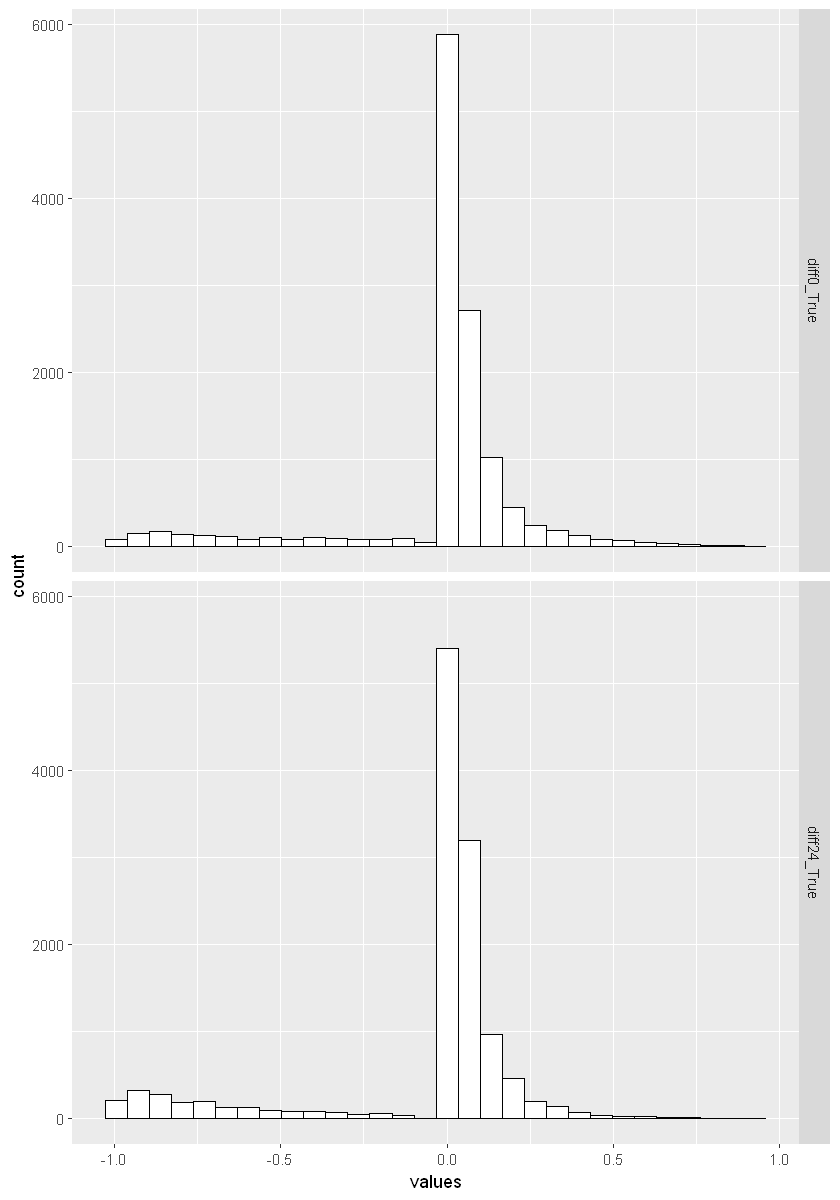

In [215]:
options(repr.plot.width=7, repr.plot.height=10)

ggplot(diff2, aes(x = values)) +
  geom_histogram(fill = "white", colour = "black") +
  facet_grid(diffs ~ .)

### 

### Check most difference first
- 0.7 or more: 3
- 0.6 or more: 11
- 0.5 or more: 33

In [246]:
diff

abs_diff0_24,count,cum_count,cumperc
<dbl>,<int>,<int>,<dbl>
0.7,3,3,0.02
0.6,8,11,0.09
0.5,22,33,0.27
0.4,79,112,0.90
0.3,206,318,2.56
0.2,501,819,6.60
0.1,1619,2438,19.63
0.0,9980,12418,100.00


### Check AUC and PRC

[1] 0.8759954

[1] 0.6425512

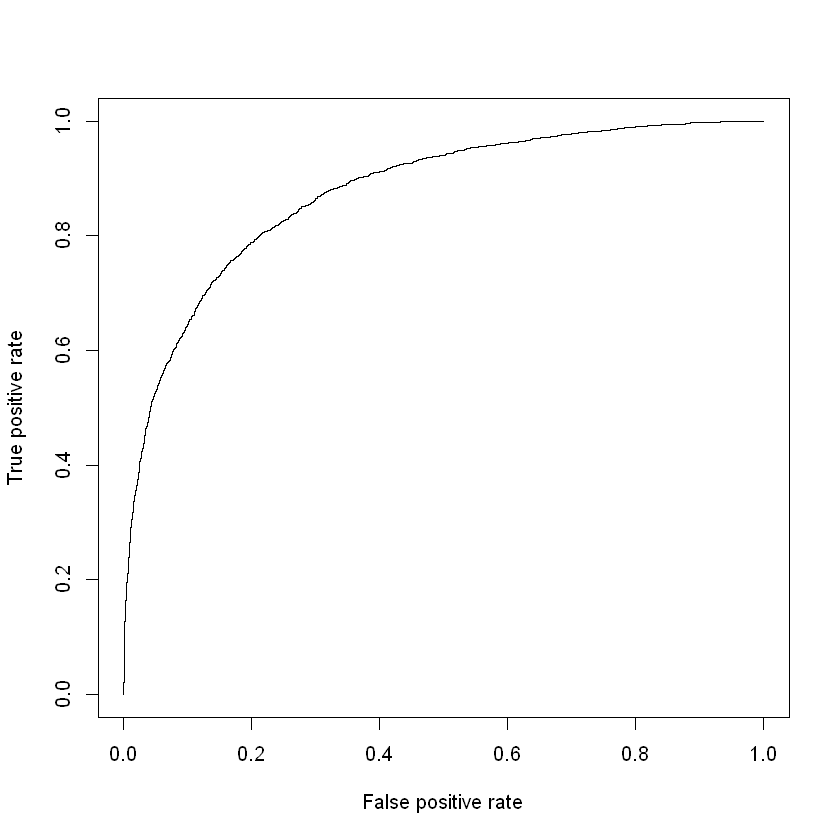

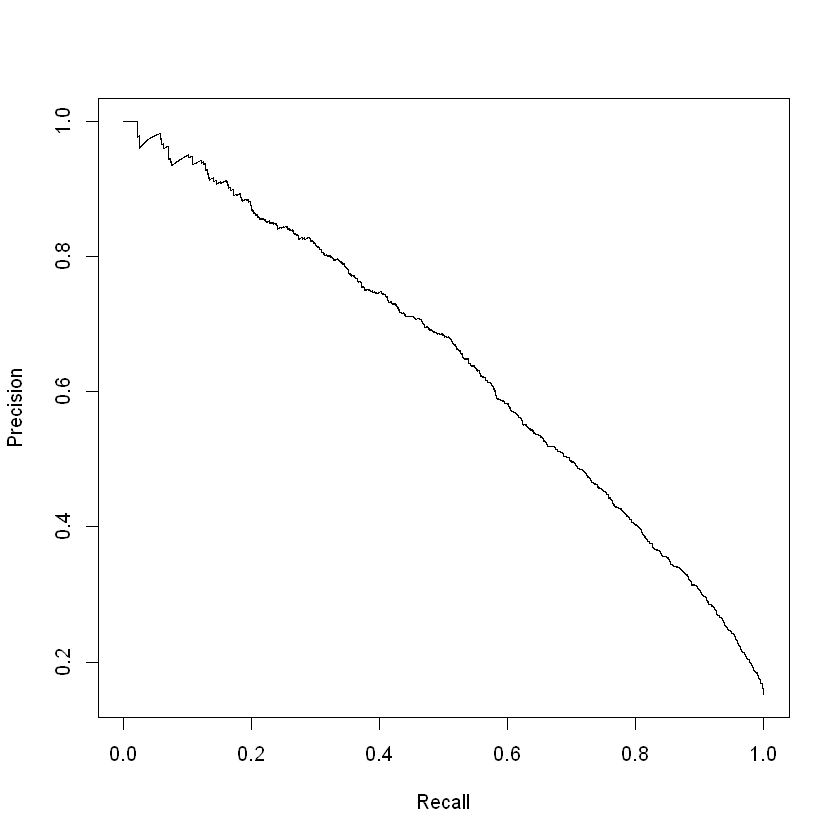

In [74]:
# get performance metrics AUC and PRC, highest level of care
options(repr.plot.width=7, repr.plot.height=7)

# pred_rocr = ROCR::prediction(cohort_test$pred_death_24hr_recent, cohort_test$death_24hr_recent_label)
pred_rocr = ROCR::prediction(cohort_test$pred_death_24hr_max, cohort_test$death_24hr_max_label)
auc = ROCR::performance(pred_rocr, measure = "auc", x.measure = "cutoff")@y.values[[1]]
prc = ROCR::performance(pred_rocr, measure = "aucpr", x.measure = "cutoff")@y.values[[1]]

PRC.perf <- ROCR::performance(pred_rocr, "prec", "rec")
ROC.perf <-  ROCR::performance(pred_rocr, "tpr", "fpr")
auc; prc

plot(ROC.perf)
plot(PRC.perf)

[1] 0.8527461

[1] 0.4911128

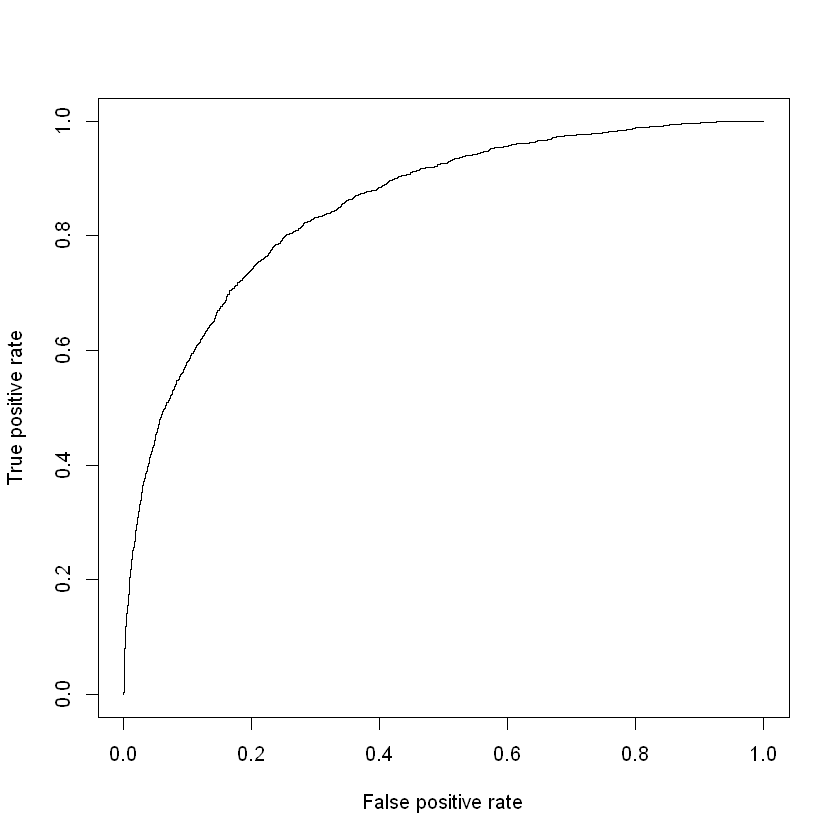

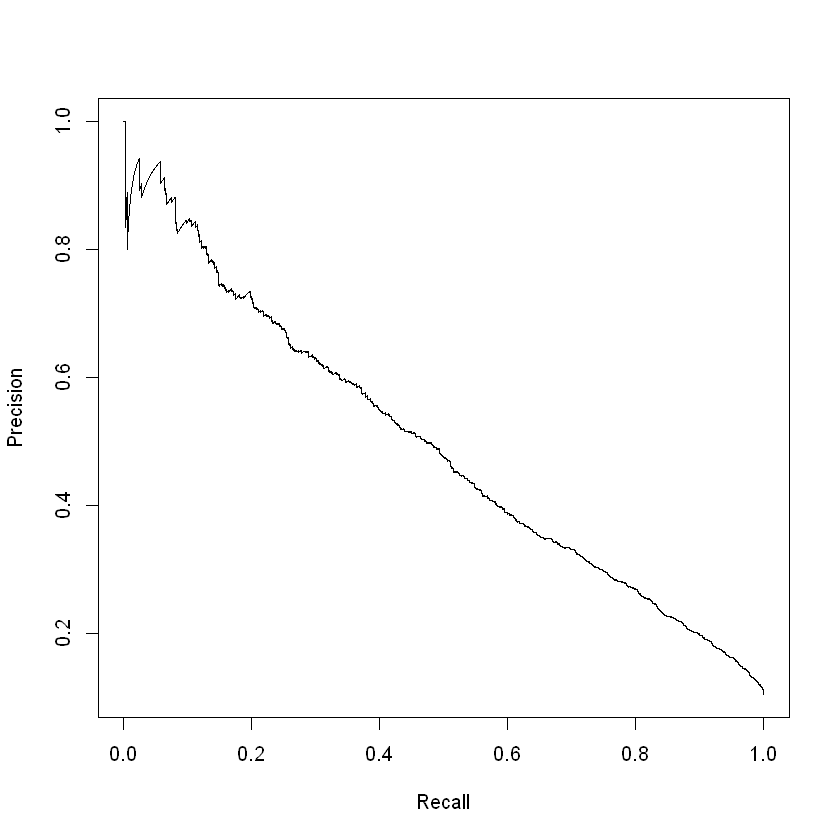

In [70]:
# get performance metrics AUC and PRC, at 24hr
options(repr.plot.width=7, repr.plot.height=7)

pred_rocr = ROCR::prediction(cohort_test$pred_death_24hr_recent, cohort_test$death_24hr_recent_label)
auc = ROCR::performance(pred_rocr, measure = "auc", x.measure = "cutoff")@y.values[[1]]
prc = ROCR::performance(pred_rocr, measure = "aucpr", x.measure = "cutoff")@y.values[[1]]

PRC.perf <- ROCR::performance(pred_rocr, "prec", "rec")
ROC.perf <-  ROCR::performance(pred_rocr, "tpr", "fpr")
auc; prc

plot(ROC.perf)
plot(PRC.perf)

[1] 0.8513965

[1] 0.487724

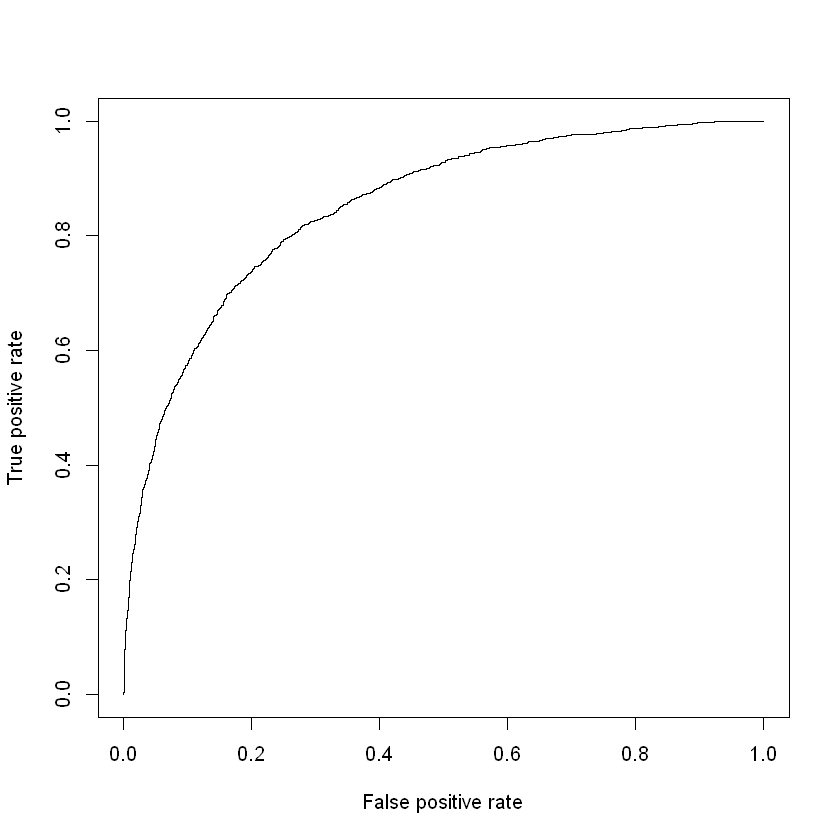

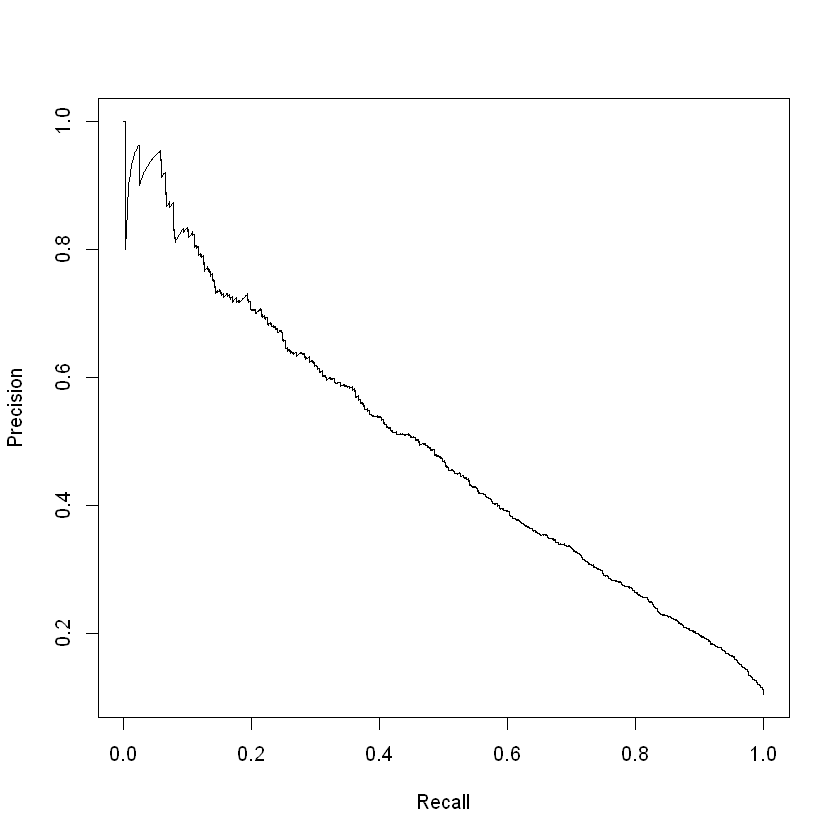

In [73]:
test2019 <- cohort_test %>% filter(adm_year==2019)
pred_rocr = ROCR::prediction(test2019$pred_death_24hr_recent, test2019$death_24hr_recent_label)
auc = ROCR::performance(pred_rocr, measure = "auc", x.measure = "cutoff")@y.values[[1]]
prc = ROCR::performance(pred_rocr, measure = "aucpr", x.measure = "cutoff")@y.values[[1]]

PRC.perf <- ROCR::performance(pred_rocr, "prec", "rec")
ROC.perf <-  ROCR::performance(pred_rocr, "tpr", "fpr")
auc; prc

plot(ROC.perf)
plot(PRC.perf)

[1] 0.9072535

[1] 0.6422387

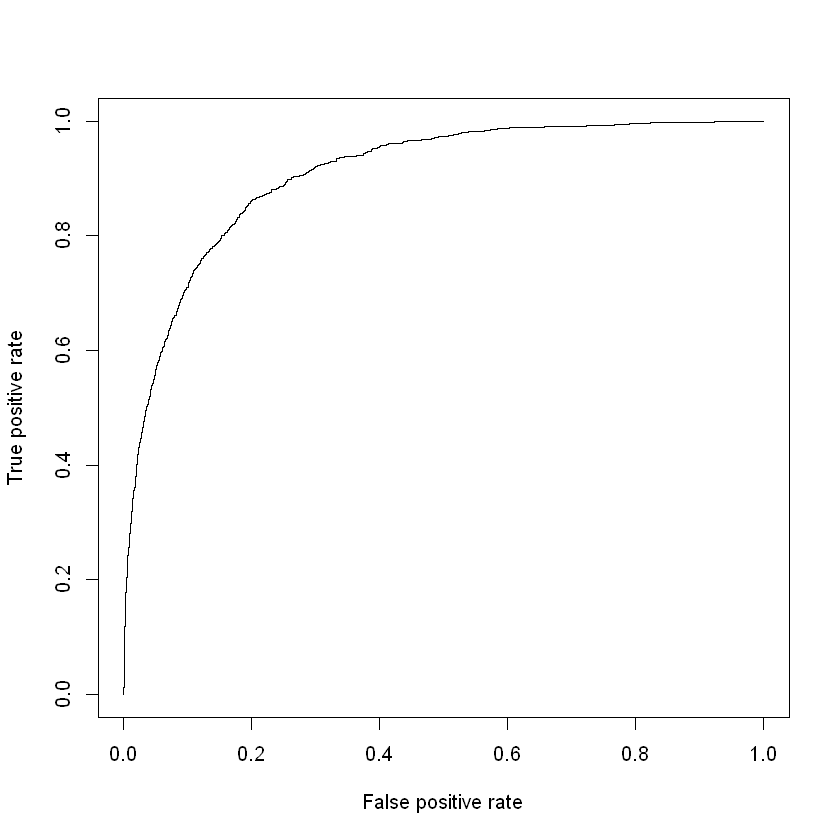

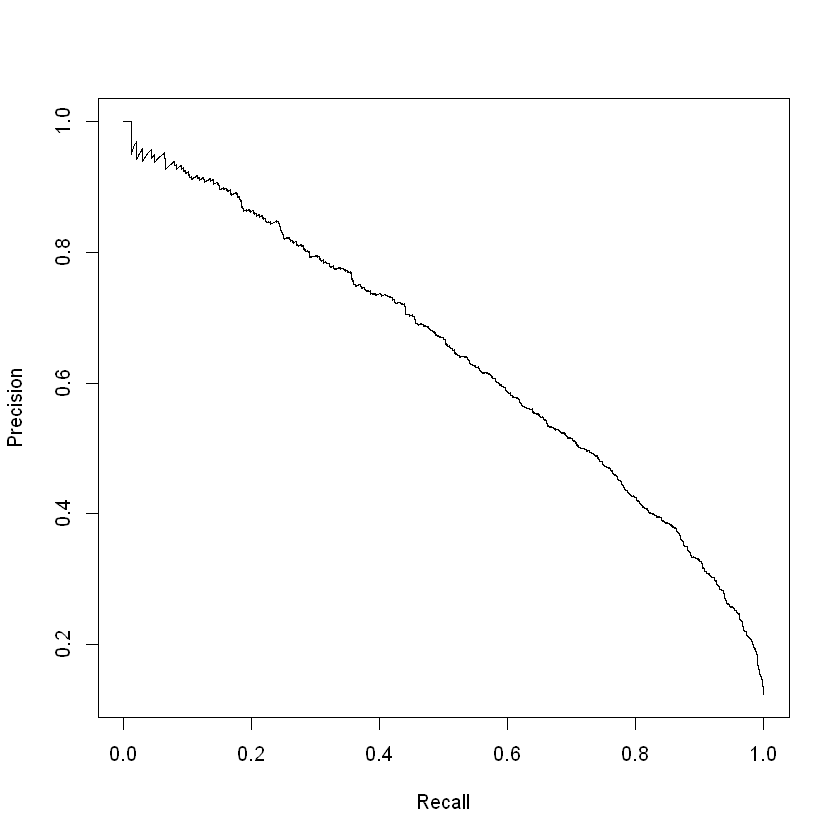

In [76]:
# get performance metrics AUC and PRC, and ACC
options(repr.plot.width=7, repr.plot.height=7)

pred_rocr = ROCR::prediction(cohort_test$pred_first, cohort_test$first_label)
auc = ROCR::performance(pred_rocr, measure = "auc", x.measure = "cutoff")@y.values[[1]]
prc = ROCR::performance(pred_rocr, measure = "aucpr", x.measure = "cutoff")@y.values[[1]]

PRC.perf <- ROCR::performance(pred_rocr, "prec", "rec")
ROC.perf <-  ROCR::performance(pred_rocr, "tpr", "fpr")
auc; prc

plot(ROC.perf)
plot(PRC.perf)